In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
x = np.arange(0, 100)
idx = pd.date_range('2018-01-01', periods = len(x))
season = pd.Series((x % 7) * 1.5, idx)
trend = pd.Series(x * 0.1, idx)
error = pd.Series(np.random.random(len(x)) * 3, idx)
y = season + trend + error

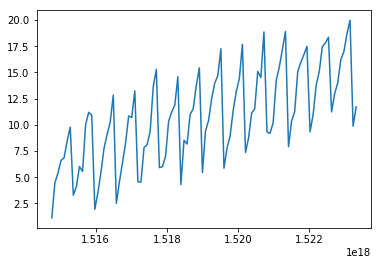

In [3]:
plt.plot(y)

In [21]:
# Implement Loess

In [4]:
def tricubic_weight(u):
    """Tricubic-Weight-Funktion"""
    result = np.power(1 - np.power(u, 3), 3)
    result[np.abs(u) > 1] = 0
    return(result)

def loess_array(u, x, y, q = None, d = 2):
    """
    u - point to be estimated
    x - independent variable
    y - dependent variable
    q - cutting point
    d - the order of the local polynomial
    """
    n = len(x)
    if q is None:
        q = np.log(len(x))
    
    if q < n:
        idx = np.argsort(np.abs(u-x))[:q]
        x_reg = x[idx]
        y_reg = y[idx]
        weights = tricubic_weight(np.abs(u - x_reg) / np.max(np.abs(u - x_reg)))
        coeff = np.polyfit(x = x_reg, y = y_reg, deg = d, w = weights)
        result = np.poly1d(coeff)(u)
    elif q >= n:
        weights = tricubic_weight(np.abs(u - x) / (np.max(np.abs(u - x)) * q / n))
        coeff = np.polyfit(x = x, y = y, deg = d, w = weights)
        result = np.poly1d(coeff)(u)
    return(result)

def loess_series(u, series, q = None, d = 2):
    """
    u - point to be estimated
    x - independent variable
    y - dependent variable
    q - cutting point
    d - the order of the local polynomial
    """
    n = len(series)
    if q is None:
        q = np.log(len(series))
    
    if q < n:
        idx = np.argsort(np.abs(u-series.index))[:q]
        x_reg = np.array((u - series.index[idx]).total_seconds())
        y_reg = series.values[idx]
        weights = tricubic_weight(np.abs(x_reg) / np.max(np.abs(x_reg)))
    elif q >= n:
        x_reg = np.array((u - series.index).total_seconds())
        y_reg = series.values
        weights = tricubic_weight(np.abs(x_reg) / (np.max(np.abs(x_reg)) * q / n))
    
    coeff = np.polyfit(x = x_reg, y = y_reg, deg = d, w = weights)
    result = np.poly1d(coeff)(0)
    return(result)

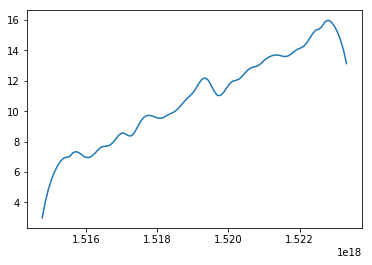

In [7]:
y_smooth = [loess_series(u, y, 20) for u in idx]
plt.plot(idx, y_smooth)

# Implementing STL

Test of inner loop

In [24]:
#Define initial values
trend_stl = pd.Series(data = 0, index = idx)
season_stl = pd.Series(data = 0, index = idx)
#Define parameters
n_p = 7 #Number of Season
n_s = 5 #Number of Values in Loess
n_i = 1 # Number of Inner Loops
n_o = 10 # Number of Outer Loops

In [25]:
detrended_stl = y - trend_stl

In [49]:
series = pd.Series()
for cycle in range(n_p):
    idx_sub = np.arange(start = cycle, stop = len(idx), step = n_p)
    points = np.arange(start = cycle - n_p, stop = len(idx) + n_p, step = n_p)
    cycle_subseries = detrended_stl[idx_sub]
    values = [loess(u, np.array(cycle_subseries.index), np.array(cycle_subseries.values), q = n_s, d = 1) for u in points]
    series = series.append(pd.Series(data = values, index = points)).sort_index()

In [ ]:
# Implement Filter

In [2]:
import statsmodels.tsa.seasonal as tsa

f:\programdata\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
tsa.seasonal_decompose(y)

AttributeError: 'Int64Index' object has no attribute 'inferred_freq'

In [6]:
y

0      1.123620
1      4.452143
2      5.395982
3      6.595975
4      6.868056
5      8.467984
6      9.774251
7      3.298528
8      4.103345
9      6.024218
10     5.561753
11    10.009730
12    11.197328
13    10.937017
14     1.945475
15     3.550214
16     5.512727
17     7.774269
18     9.095835
19    10.273687
20    12.835559
21     2.518482
22     4.576434
23     6.399086
24     8.268210
25    10.855528
26    10.699021
27    13.242703
28     4.577244
29     4.539351
        ...    
70     9.316734
71     9.196147
72    10.216566
73    14.246384
74    15.520572
75    17.187022
76    18.913811
77     7.922134
78    10.375397
79    11.247607
80    15.089310
81    15.969894
82    16.692694
83    17.490675
84     9.332947
85    10.975550
86    13.788819
87    15.112672
88    17.461638
89    17.816645
90    18.358783
91    11.239734
92    12.982355
93    13.983832
94    16.212902
95    16.981387
96    18.668198
97    19.982623
98     9.876257
99    11.723674
Length: 100, dtype: floa